# Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from copy import deepcopy
from keras.datasets import mnist

# Download Data

In [2]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


# Pre-Processing Data

In [3]:
# x_train and x_valid
x_train_flatten = x_train_raw.reshape(x_train_raw.shape[0], -1).T
x_train_normalized = x_train_flatten / 255
x_train = x_train_normalized[:, round(0.2 * x_train_normalized.shape[1]):]
x_valid = x_train_normalized[:, :round(0.2 * x_train_normalized.shape[1])]

# y_train and y_valid
y_train_one_hotted = tf.keras.utils.to_categorical(y_train_raw, 10).T
y_train = y_train_one_hotted[:, round(0.2 * y_train_one_hotted.shape[1]):]
y_valid = y_train_one_hotted[:, :round(0.2 * y_train_one_hotted.shape[1])]

# x_test
x_test_flatten = x_test_raw.reshape(x_test_raw.shape[0], -1).T
x_test = x_test_flatten / 255

# y_test
y_test = tf.keras.utils.to_categorical(y_test_raw, 10).T

# Print Data's Shape

In [4]:
print(f"x_train : {x_train.shape}",
      f"y_train : {y_train.shape}", 
      sep=" --> ")

print(f"x_valid : {x_valid.shape}",
      f"y_valid : {y_valid.shape}", 
      sep=" --> ")

print(f"x_test : {x_test.shape}",
      f"y_test : {y_test.shape}", 
      sep=" --> ")

x_train : (784, 48000) --> y_train : (10, 48000)
x_valid : (784, 12000) --> y_valid : (10, 12000)
x_test : (784, 10000) --> y_test : (10, 10000)


# Math Functions

In [5]:
def relu(Z):

    R = np.maximum(0, Z)
    relu_cache = Z

    return R, relu_cache

In [6]:
def softmax(Z):

    exp_Z = np.exp(Z)
    exp_sum = np.sum(exp_Z, axis=0, keepdims=True)
    
    S = exp_Z / exp_sum
    softmax_cache = Z

    return S, softmax_cache

In [7]:
def sigmoid(Z):

    S = 1 / (1 + np.exp(-Z))
    sigmoid_cache = Z

    return S, sigmoid_cache

In [8]:
def backward_relu(dA, relu_cache):

    Z = relu_cache
    
    dZ = deepcopy(dA)
    dZ[Z <= 0] = 0

    return dZ

In [9]:
def backward_softmax(dA, softmax_cache):

    Z = softmax_cache
  
    exp_Z = np.exp(Z)
    exp_sum = np.sum(exp_Z, axis=0, keepdims=True)

    S = exp_Z / exp_sum
    dZ = dA * S * (1 - S)

    return dZ

In [10]:
def backward_sigmoid(dA, sigmoid_cache):

    Z = sigmoid_cache

    S = 1 / (1 + np.exp(-Z))
    dZ = dA * S * (1 - S)

    return dZ

# MLP Functions

In [11]:
# this function creats weights and biases
def weight_initializer(layers):

    M = len(layers)
    weights = dict()
    weights_momentum = dict()
    weights_dbar = dict()

    # building the weights for an M layer preceptron model
    for m in range(1, M):

        # normal weights
        weights[f"W{m}"] = np.random.randn(layers[m], layers[m - 1]) * 0.01
        weights[f"b{m}"] = np.zeros((layers[m], 1))

        # auxiliary weights for momentum method
        weights_momentum[f"Wm{m}"] = np.zeros((layers[m], layers[m - 1]))
        weights_momentum[f"bm{m}"] = np.zeros((layers[m], 1))

        # auxiliary weights for delta-bar-delta method
        weights_dbar[f"Wd{m}"] = np.zeros((layers[m], layers[m - 1]))
        weights_dbar[f"bd{m}"] = np.zeros((layers[m], 1))

    return weights, weights_momentum, weights_dbar

In [12]:
# this function calculates the net for each neurons
def forward_net(A_old, W, b):

    # calculating the net for each neurons (for all inputs)
    Z = np.dot(W, A_old) + b
    net_cache = (A_old, W, b)

    return Z, net_cache

In [13]:
# this function calculates the activated net for each neurons
def forward_active(A_old, W, b, active_func="relu"):

    # constructing a layer with relu activation funciton
    if active_func == "relu":

        Z, net_cache = forward_net(A_old, W, b)
        A_new, relu_cache = relu(Z)
        active_cache = (net_cache, relu_cache)

    # constructing a layer with softmax activation funciton
    elif active_func == "softmax":

        Z, net_cache = forward_net(A_old, W, b)
        A_new, softmax_cache = softmax(Z)
        active_cache = (net_cache, softmax_cache)

    # constructing a layer with sigmoid activation funciton
    elif active_func == "sigmoid":

        Z, net_cache = forward_net(A_old, W, b)
        A_new, sigmoid_cache = sigmoid(Z)
        active_cache = (net_cache, sigmoid_cache)

    else:

        raise TypeError(f"{active_func} is not a supported activation function")

    return A_new, active_cache

In [14]:
# this function calculates the overall forward propagation path
def forward_propagation(x_train, weights, last_layer_activation):

    M = len(weights) // 2
    A_old = deepcopy(x_train)
    propagation_cache = list()

    # constructing M-1 hidden layers
    for m in range(1, M):

        A_new, active_cache = forward_active(A_old, weights[f"W{m}"], weights[f"b{m}"])
        propagation_cache.append(active_cache)
        A_old = deepcopy(A_new)

    # constructing output layer
    AL, active_cache = forward_active(A_old, weights[f"W{M}"], weights[f"b{M}"], 
                                    active_func=last_layer_activation)

    propagation_cache.append(active_cache)

    return AL, propagation_cache

In [15]:
# this function calculates the gradient of cost function with resepect to A, W, b
def backward_net(dZ, net_cache):
  
    A_old, W, b = net_cache
    M = A_old.shape[1]

    # calulating the gradeint of cost function with respect to A, W, b (for all inputs)
    dW = (1 / M) * np.dot(dZ, A_old.T)
    db = (1 / M) * np.sum(dZ, axis=1, keepdims=True)
    dA = np.dot(W.T, dZ)

    return dA, dW, db

In [16]:
# this function calculates the gradient with respect to activation function
def backward_active(dA, active_cache, active_func="relu"):

    # calculate the gradients for a layer with relu activation function
    if active_func == "relu":
        
        net_cache, relu_cache = active_cache
        dZ = backward_relu(dA, relu_cache)
        dA, dW, db = backward_net(dZ, net_cache)

    # calculate the gradients for a layer with softmax activation function
    elif active_func == "softmax":
        
        net_cache, softmax_cache = active_cache
        dZ  = backward_softmax(dA, softmax_cache)
        dA, dW, db = backward_net(dZ, net_cache)

    # calculate the gradients for a layer with sigmoid activation function
    elif active_func == "sigmoid":

        net_cache, sigmoid_cache = active_cache
        dZ = backward_sigmoid(dA, sigmoid_cache)
        dA, dW, db = backward_net(dZ, net_cache)

    else:

        raise TypeError(f"{active_func} is not a supported activation function")
        
    return dA, dW, db

In [17]:
# this function calculates the overall baceward propagation path
def backward_propagation(AL, y_train, propagation_cache, last_layer_activation):
  
    grads = dict()
    M = len(propagation_cache)
    
    # calculating the gradients for output layer
    dAL = (y_train - AL)
    active_cache = propagation_cache[-1]
    dA_old, dW, db = backward_active(dAL, active_cache, active_func=last_layer_activation)
    
    grads[f"dW{M}"] = dW
    grads[f"db{M}"] = db
    grads[f"dA_old{M - 1}"] = dA_old

    for m in reversed(range(M - 1)):

        # calculating the gradients for hidden layers
        active_cache = propagation_cache[m]
        dA_old, dW, db = backward_active(grads[f"dA_old{m + 1}"], active_cache)
        
        grads[f"dW{m + 1}"] = dW
        grads[f"db{m + 1}"] = db
        grads[f"dA_old{m}"] = dA_old

    return grads

In [18]:
# this function updates the learning rate for delta bar delta method
def update_learning_rate(learning_rate, weights_dbar, grads):

    M = len(learning_rate) // 2

    # delta-bar-delta method's constants(copied from pamphlet)
    beta=0.7; landa=0.3333; k=0.035

    for m in range(1, M + 1):
        
        # calculating the condition for update
        W_condition = weights_dbar[f"Wd{m}"] * grads[f"dW{m}"]
        b_condition = weights_dbar[f"bd{m}"] * grads[f"db{m}"]

        # updating learning rate for weights
        learning_rate[f"Wd{m}"][W_condition > 0] += k
        learning_rate[f"Wd{m}"][W_condition < 0] *= (1 - landa)

        # updating learning rate for biases
        learning_rate[f"bd{m}"][b_condition > 0] += k
        learning_rate[f"bd{m}"][b_condition < 0] *= (1 - landa)

        # updating dbar weights
        weights_dbar[f"Wd{m}"] = (1 - beta) * grads[f"dW{m}"] + beta * weights_dbar[f"Wd{m}"]
        weights_dbar[f"bd{m}"] = (1 - beta) * grads[f"db{m}"] + beta * weights_dbar[f"bd{m}"]

    return learning_rate, weights_dbar

In [19]:
# this function updates the weights and biases with the use of their gradient
def update_weights(weights, weights_momentum, grads, learning_rate, momentum, dbar_method):

    M = len(weights) // 2
    
    # if delta-bar-delta method is not used
    if dbar_method == False:
        
        for m in range(1, M + 1):
        
            # updating weights
            weights[f"W{m}"], weights_momentum[f"Wm{m}"] = \
                weights[f"W{m}"] + learning_rate * grads[f"dW{m}"] + \
                momentum * (weights[f"W{m}"] - weights_momentum[f"Wm{m}"]), weights[f"W{m}"]

            # updaing biases
            weights[f"b{m}"], weights_momentum[f"bm{m}"] = \
                weights[f"b{m}"] + learning_rate * grads[f"db{m}"] + \
                momentum * (weights[f"b{m}"] - weights_momentum[f"bm{m}"]), weights[f"b{m}"]

    # if delta-bar-delta method is used
    elif dbar_method == True:

        for m in range(1, M + 1):

            # updating weights
            weights[f"W{m}"], weights_momentum[f"Wm{m}"] = \
                weights[f"W{m}"] + learning_rate[f"Wd{m}"] * grads[f"dW{m}"] + \
                momentum * (weights[f"W{m}"] - weights_momentum[f"Wm{m}"]), weights[f"W{m}"]

            # updating biases
            weights[f"b{m}"], weights_momentum[f"bm{m}"] = \
                weights[f"b{m}"]  + learning_rate[f"bd{m}"] * grads[f"db{m}"] + \
                momentum * (weights[f"b{m}"] - weights_momentum[f"bm{m}"]), weights[f"b{m}"]

    return weights, weights_momentum

In [20]:
# this function computes the cost (the cost function is SSE)
def cost_computer(AL, y_train):

    M = y_train.shape[1]
    # compute the cost for each input
    loss = (1 / 2) * np.sum(np.power((AL - y_train), 2), axis=0, keepdims=True)

    # compute the cost for all inputs
    cost = (1 / M) * np.sum(loss, axis=1, keepdims=True)
    cost = np.squeeze(cost)
    
    return cost

In [21]:
# this function computes the accuracy
def accuracy_computer(AL, y_train):

    M = AL.shape[1]
    AL_prime = deepcopy(AL)

    # obtain the one-hotted version of AL (MAX --> 1, O.W --> 0)
    AL_prime[np.max(AL, axis=0, keepdims=True) == AL] = 1
    AL_prime[np.max(AL, axis=0, keepdims=True) != AL] = 0

    # compute the accuracy based of labels(y_train) and one-hotted AL
    accuracy = 1 - (np.sum(np.abs(AL_prime - y_train)) / (2 * M))

    return accuracy

In [22]:
# this function evaluates the model useing achieved weights
def evaluate(X, Y, weights, last_layer_activation):

    # forward path to obtain AL
    AL, _  = forward_propagation(X, weights, last_layer_activation)

    # compute cost and accuracy with respect to AL 
    cost = cost_computer(AL, Y)
    accuracy = accuracy_computer(AL, Y)

    return cost, accuracy

In [23]:
# this function gathers all previous functions and build the MLP model
def MLP_Model(x_train, y_train, x_valid, y_valid, layers, epochs, last_layer_activation="softmax", 
             epoch_show_size=10, learning_rate=1, momentum=0, dbar_method=False):

    # initializing weights
    weights, weights_momentum, weights_dbar = weight_initializer(layers)

    # building learning rate for delta bar delta method
    if dbar_method == True:

        learning_rate_temp = dict()

        for key in weights_dbar.keys():

            learning_rate_temp[key] = weights_dbar[key] + learning_rate

        learning_rate = deepcopy(learning_rate_temp)

    # list for adding cost and accuracy
    train_costs = list()
    train_accuracies = list()
    valid_costs = list()
    valid_accuracies = list()

    # forward path to obtain initial condition (first time)
    AL, propagation_cache = forward_propagation(x_train, weights, last_layer_activation)
    
    # cost and accuracy of train data for initial condition (befor any weights update)
    train_cost = cost_computer(AL, y_train)
    train_accuracy = accuracy_computer(AL, y_train)

    # cost and accuracy of validation data for initial condition (befor any weights update)
    valid_cost, valid_accuracy = evaluate(x_valid, y_valid, weights, last_layer_activation)

    # printing the results for initial condition
    print(f"initial condition :\n {' ' * 5} "
            f"[train cost = {train_cost:.5f}] - [train accuracy = {train_accuracy:.5f}] | "
            f"[valid cost = {valid_cost:.5f}] - [valid accuracy = {valid_accuracy:.5f}] \n"
            f"{' ' * 4 + '-' * 110}")

    # recording train cost and accuracy for initial condition
    train_costs.append(train_cost)
    train_accuracies.append(train_accuracy)

    # recording validation cost and accuracy for initial condition
    valid_costs.append(valid_cost)
    valid_accuracies.append(valid_accuracy)

    # this loop
    for epoch in range(1, epochs + 1):

        # backward path
        grads = backward_propagation(AL, y_train, propagation_cache, last_layer_activation)

        # update learning rate (for dalta bar delta method)
        if dbar_method == True:

            learning_rate, weights_dbar = update_learning_rate(learning_rate, weights_dbar, grads)

        # updating weights
        weights, weights_momentum = update_weights(weights, weights_momentum, grads,
                                                    learning_rate, momentum, dbar_method)

        # forward path
        AL, propagation_cache = forward_propagation(x_train, weights, last_layer_activation)

        # cost and accuracy of train data
        train_cost = cost_computer(AL, y_train)
        train_accuracy = accuracy_computer(AL, y_train)

        # cost and accuracy of validation data
        valid_cost, valid_accuracy = evaluate(x_valid, y_valid, weights, last_layer_activation)

        # printing the results, with respect to epoch_show_size
        if (epoch) % epoch_show_size == 0:

            print(f"Epoch {epoch}/{epochs} :\n {' ' * 5} "
                    f"[train cost = {train_cost:.5f}] - [train accuracy = {train_accuracy:.5f}] | "
                    f"[valid cost = {valid_cost:.5f}] - [valid accuracy = {valid_accuracy:.5f}] \n"
                    f"{' ' * 4 + '-' * 110}")

        # recording current train cost and accuracy
        train_costs.append(train_cost)
        train_accuracies.append(train_accuracy)

        # recording current validation cost and accuracy
        valid_costs.append(valid_cost)
        valid_accuracies.append(valid_accuracy)

    metrics = (train_costs, train_accuracies, valid_costs, valid_accuracies)

    return weights, metrics

# Training a MLP Model with M Hidden Layers

In [25]:
layers = [784, 32, 10]
epochs = 10
weights, metrics = MLP_Model(x_train, y_train, x_valid, y_valid, layers, epochs,
                             last_layer_activation="softmax", epoch_show_size=1,
                             learning_rate=1e-1)

(train_costs, train_accuracies, valid_costs, valid_accuracies) = metrics

initial condition :
       [train cost = 0.44995] - [train accuracy = 0.14869] | [valid cost = 0.44995] - [valid accuracy = 0.14975] 
    --------------------------------------------------------------------------------------------------------------
Epoch 1/10 :
       [train cost = 0.44995] - [train accuracy = 0.14940] | [valid cost = 0.44995] - [valid accuracy = 0.15017] 
    --------------------------------------------------------------------------------------------------------------
Epoch 2/10 :
       [train cost = 0.44995] - [train accuracy = 0.15019] | [valid cost = 0.44995] - [valid accuracy = 0.15025] 
    --------------------------------------------------------------------------------------------------------------
Epoch 3/10 :
       [train cost = 0.44995] - [train accuracy = 0.15117] | [valid cost = 0.44994] - [valid accuracy = 0.15108] 
    --------------------------------------------------------------------------------------------------------------
Epoch 4/10 :
       [trai

# Evaluation of the Model

In [ ]:
# evaluating the model with test data
cost, accuracy = evaluate(x_test, y_test, weights, last_layer_activation="softmax")
print(f"Test Data : [cost = {cost:.5f}] | [accuracy = {accuracy:.5f}]")

Test Data : [cost = 0.05268] | [accuracy = 0.93300]


# Plotting the Results

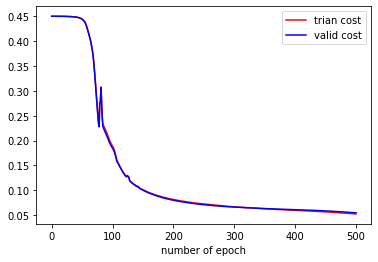

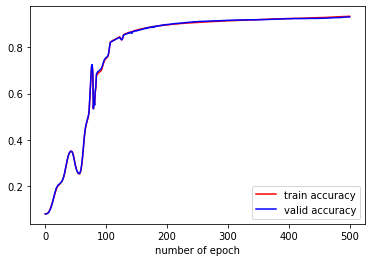

In [ ]:
# plotting the train and validation cost vs epochs
plt.plot(range(epochs + 1), train_costs, "r")
plt.plot(range(epochs + 1), valid_costs, "b")
plt.xlabel("number of epoch")
plt.legend(["trian cost", "valid cost"])
plt.show()

# plotting the cost and validation accuracy vs epochs
plt.plot(range(epochs + 1), train_accuracies, "r")
plt.plot(range(epochs + 1), valid_accuracies, "b")
plt.xlabel("number of epoch")
plt.legend(["train accuracy", "valid accuracy"])
plt.show()